In [1]:
import pandas as pd
import numpy as np
import anndata
import joblib
import pybedtools
import seaborn as sns
import pyBigWig
import matplotlib.pyplot as plt
import pathlib

In [2]:
from matplotlib import rc

labelsize = 8
linewidth = 0.5
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Load

In [3]:
reptile_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/REPTILE/result/REPTILE_scores.subtype.h5ad'
)
enhancer_hits = pd.Series((reptile_adata.X > 0.5).sum(axis=1).A1,
                          index=reptile_adata.obs_names)
use_dmr = enhancer_hits[enhancer_hits > 3].index

In [4]:
dmr_rate = pd.read_hdf(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5',
    key='Rate').loc[use_dmr].copy()

dmr_bed = pd.read_hdf(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5',
    key='bed').loc[use_dmr].copy()

In [5]:
cluster_order = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/CompareREPTILE/EnhancerDevProfile/SubtypeOrder.txt',
    header=None,
    index_col=0).index

In [6]:
encode_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/study/CompareREPTILE/AnnotateDMRWithENCODE/SubType.DMR.ENCODE_FB_anno.h5ad'
)[use_dmr, :].copy()

encode_adata = encode_adata[:,
                            encode_adata.var.sort_values(
                                ['DataType', 'DevTime', 'Rep']).index].copy()

In [7]:
dmr_corr = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/TotalGeneDMRCorrLoop.0.3.msg'
)
dmr_corr = dmr_corr[dmr_corr['DMR'].isin(use_dmr)].copy()

gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    index_col='gene_id',
    sep='\t')
gene_name_to_id = {n: i for i, n in gene_meta['gene_name'].items()}

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
fedmr_bed = pybedtools.BedTool(
    '/home/hanliu/ref/inhouse/He_2020_Nature_Mouse_Tissue_Developmental/feDMR_FB.bed'
)

fedmr_ids = pybedtools.BedTool.from_dataframe(
    dmr_bed.reset_index().iloc[:, [1, 2, 3, 0]]).intersect(
        fedmr_bed, wa=True, u=True).to_dataframe()['name'].values

is_fedmr = use_dmr.isin(fedmr_ids)
is_fedmr = pd.Series(is_fedmr, index=use_dmr)

dmr_corr['is_fedmr'] = dmr_corr['DMR'].map(is_fedmr)

## Gene profile

In [9]:
gene_profile = pd.DataFrame([dmr_corr.groupby('Gene').apply(lambda i: i.shape[0])]).T
gene_profile.columns = ['# DMR']
gene_profile['feDMR%'] = dmr_corr.groupby('Gene').apply(lambda i: i['is_fedmr'].sum() / i.shape[0]) * 100
gene_profile['gene_name'] = gene_profile.index.map(gene_meta['gene_name'])

In [10]:
gene_profile = gene_profile[~(
    gene_profile['gene_name'].str.startswith('Gm')
    | gene_profile['gene_name'].str.endswith('Rik') | gene_profile['gene_name']
    .apply(lambda i: i[:2] in ['BX', 'BC', 'AA', 'AC', 'AL', 'CR', 'CA', 'CT', 'RF']))].copy()

In [11]:
gene_profile['# DMR cap'] = gene_profile['# DMR'].apply(lambda i: i if i < 600 else 600)


In [12]:
gene_profile = gene_profile[gene_profile['# DMR'] > 50].copy()

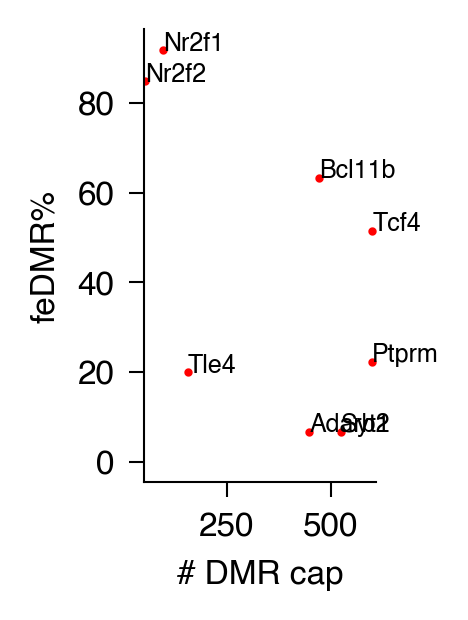

In [15]:
fig, ax = plt.subplots(figsize=(1, 2), dpi=300)

sns.scatterplot(ax=ax, data=gene_profile, x='# DMR cap', y='feDMR%', 
                s=1, linewidth=0, color='black')

# judges = [(gene_profile['# DMR'] > 50) & (gene_profile['feDMR%'] > 80),
#           (gene_profile['# DMR'] > 300) & (gene_profile['feDMR%'] > 70),
#           (gene_profile['# DMR'] > 300) & (gene_profile['feDMR%'] < 10),
#           (gene_profile['# DMR'] > 400) & (gene_profile['feDMR%'] > 60),
#           (gene_profile['# DMR'] > 580)]
# 
# total_judge = np.any(judges, axis=0)
gene_names = [
    'Tle4', 'Bcl11b', 'Nr2f1', 'Nr2f2', 'Tcf4', 'Syt1', 'Ptprm', 'Adarb2'
]

gene_to_annot = gene_profile.loc[gene_profile['gene_name'].isin(gene_names)]

ax.collections[0].remove()

for _, (_, y, gene_name, x) in gene_to_annot.iterrows():
    ax.text(x, y, gene_name, fontsize=6)
    ax.scatter(x, y, s=1, c='r')

ax.set(xlim=(50, 610))
sns.despine(ax=ax)

fig.savefig('DMRProfile.pdf')

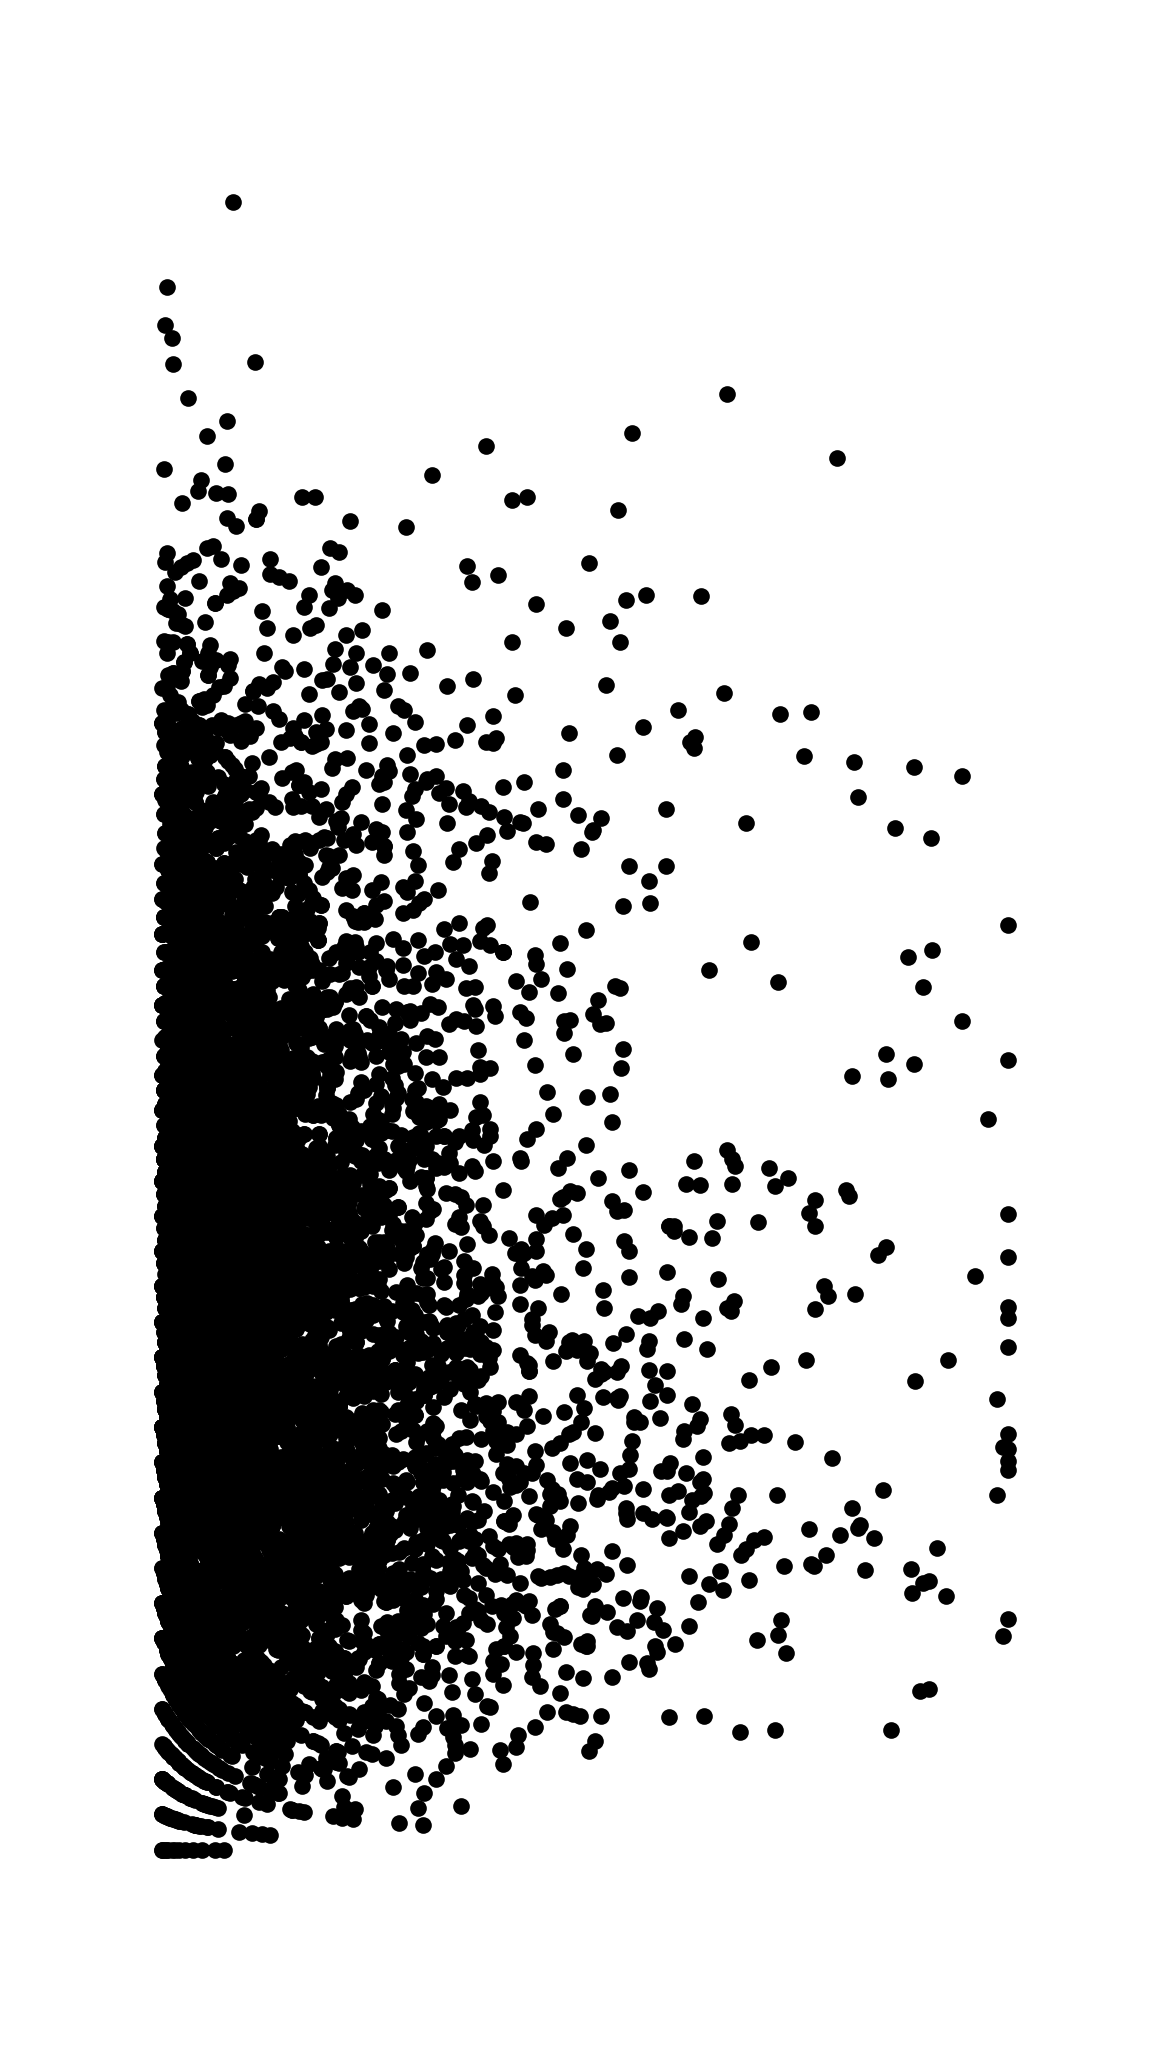

In [16]:
fig, ax = plt.subplots(figsize=(1, 2), dpi=1200)

sns.scatterplot(ax=ax, data=gene_profile, x='# DMR cap', y='feDMR%', 
                s=1, linewidth=0, color='black')

# judges = [(gene_profile['# DMR'] > 50) & (gene_profile['feDMR%'] > 80),
#           (gene_profile['# DMR'] > 300) & (gene_profile['feDMR%'] > 70),
#           (gene_profile['# DMR'] > 300) & (gene_profile['feDMR%'] < 10),
#           (gene_profile['# DMR'] > 400) & (gene_profile['feDMR%'] > 60),
#           (gene_profile['# DMR'] > 580)]
# 
# total_judge = np.any(judges, axis=0)
gene_names = [
    'Tle4', 'Bcl11b', 'Nr2f1', 'Nr2f2', 'Tcf4', 'Syt1', 'Ptprm', 'Adarb2'
]

gene_to_annot = gene_profile.loc[gene_profile['gene_name'].isin(gene_names)]

ax.axis('off')
fig.savefig('DMRProfile.png')